# First  Try at making NN with mesh input (as a graph)

- Creating the dataset from mesh files and solver times (node based), log-transform of time available
- Creating the grapth neural network (two simple models) for regression

In [2]:
import sys
print(sys.executable)


c:\Users\aol053\.conda\envs\mytorch\python.exe


In [3]:
import os
import time
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Dataset, Data
import meshio

In [4]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import contextlib # to suppress output

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
df = pd.read_csv("D:/ML4pmg/Data_Large2/solver_times.csv")
df.head()

,Mesh #,Fractures #,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s),Solver Label,Adjusted Time (s)
0,0,53,0,gmres,ilu,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + ilu + ilu,4.221818
1,0,53,1,gmres,sor,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + sor + ilu,4.221818
2,0,53,2,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + jacobi + ilu,4.221818
3,0,53,3,gmres,bjacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + bjacobi + ilu,4.221818
4,0,53,4,gmres,asm,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + asm + ilu,4.221818


## Create the MeshSolverDataset object

In [9]:
class TwoHeadedDataset(Dataset):
    def __init__(self, mesh_dir, csv_path, transform=None, pre_transform=None, log_transform=True):
        super().__init__(mesh_dir, transform, pre_transform)
        self.mesh_dir = mesh_dir
        self.csv = pd.read_csv(csv_path)

        # Pivot for regression target: Total Time (s), indexed by Combination #
        self.mesh_times = self.csv.pivot_table(
            index='Mesh #',
            columns='Combination #',
            values='Adjusted Time (s)'
        ).sort_index()

        if log_transform:
            self.mesh_times = self.mesh_times.applymap(lambda x: -np.log(abs(x) + 1e-6))
        else:
            self.mesh_times = self.mesh_times.applymap(lambda x: abs(x))

        # Pivot for classification target: Converged (True/False)
        self.mesh_convergence = self.csv.pivot_table(
            index='Mesh #',
            columns='Combination #',
            values='Converged'
        ).sort_index()

        # Convert boolean to float (0.0 or 1.0)
        self.mesh_convergence = self.mesh_convergence.astype(float)

        assert list(self.mesh_times.columns) == list(self.mesh_convergence.columns)

        self.mesh_ids = self.mesh_times.index.tolist()
        self.combination_ids = self.mesh_times.columns.tolist()  # Should be [0, 1, ..., 20]

    def len(self):
        return len(self.mesh_ids)

    def get(self, idx):
        mesh_id = self.mesh_ids[idx]
        mesh_filename = f"mesh2d_Xfr_{mesh_id:04d}.msh"
        mesh_path = os.path.join(self.mesh_dir, mesh_filename)

        # Read mesh
        mesh = meshio.read(mesh_path)
        coords = mesh.points.astype(np.float32)
        triangles = mesh.cells_dict.get("triangle")
        if triangles is None:
            raise ValueError(f"No triangle elements in {mesh_filename}")

        # Extract edges from triangles
        edge_index_list = []
        for tri in triangles:
            i, j, k = tri
            edge_index_list += [(i, j), (j, k), (k, i)]

        edge_index = torch.tensor(list(set(edge_index_list)), dtype=torch.long).t().contiguous()
        x = torch.tensor(coords, dtype=torch.float32)

        # Regression target: Total Time (s)
        y_time = torch.tensor(self.mesh_times.loc[mesh_id].values.astype(np.float32))

        # Classification target: Converged
        y_conv = torch.tensor(self.mesh_convergence.loc[mesh_id].values.astype(np.float32))

        data = Data(x=x, edge_index=edge_index, y_time=y_time, y_conv=y_conv)
        data.mesh_id = mesh_id
        return data



In [10]:
dataset = TwoHeadedDataset(
    mesh_dir="D:/ML4pmg/Data_Large2/",
    csv_path="D:/ML4pmg/Data_Large2/solver_times.csv",
    log_transform=True
)

print(f"Loaded {len(dataset)} graphs")
print(dataset[0])


Loaded 1000 graphs

Data(x=[9958, 3], edge_index=[2, 58971], y_time=[18], y_conv=[18], mesh_id=0)


In [11]:
data = dataset[0]
print(data.y_time) 
print(data.y_conv) 


tensor([-1.4403, -1.4403, -1.4403, -1.4403, -1.4403, -1.4403, -1.4403, -1.4403,
        -1.4403, -1.4403, -1.4403, -1.4403, -1.4403, -1.4403, -1.4403, -1.4403,
        -1.4403, -1.4403])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


### Load the mesh_Id for balancing the data, created in Data_Large_Analysis

In [12]:
balanced_mesh_ids = np.loadtxt("Data_Large2/balanced_mesh_ids.csv", dtype=int).tolist()
len(balanced_mesh_ids)

450

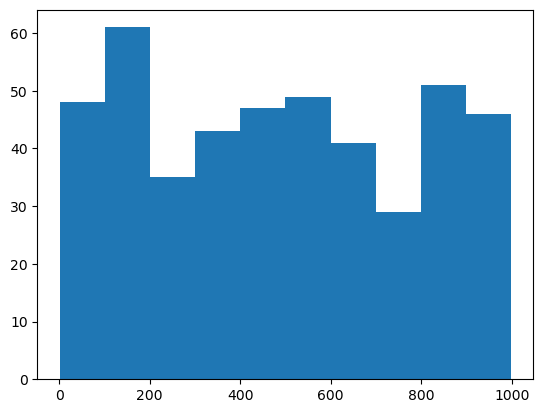

In [13]:
plt.hist(balanced_mesh_ids, bins = 10);

In [16]:
class FilteredTwoHeadedDataset(TwoHeadedDataset):
    def __init__(self, mesh_dir, csv_path, selected_mesh_ids, **kwargs):
        super().__init__(mesh_dir, csv_path, **kwargs)

        # Override mesh_ids with the provided list (with duplicates)
        self.mesh_ids = selected_mesh_ids



allowed_ids = set(balanced_mesh_ids)
dataset = FilteredTwoHeadedDataset(
    mesh_dir="D:/ML4pmg/Data_Large2/",
    csv_path="D:/ML4pmg/Data_Large2/solver_times.csv",
    selected_mesh_ids=balanced_mesh_ids,
    log_transform=True)
print(f"{len(dataset)} graphs loaded")

450 graphs loaded


## Visualize few samples in the dataset

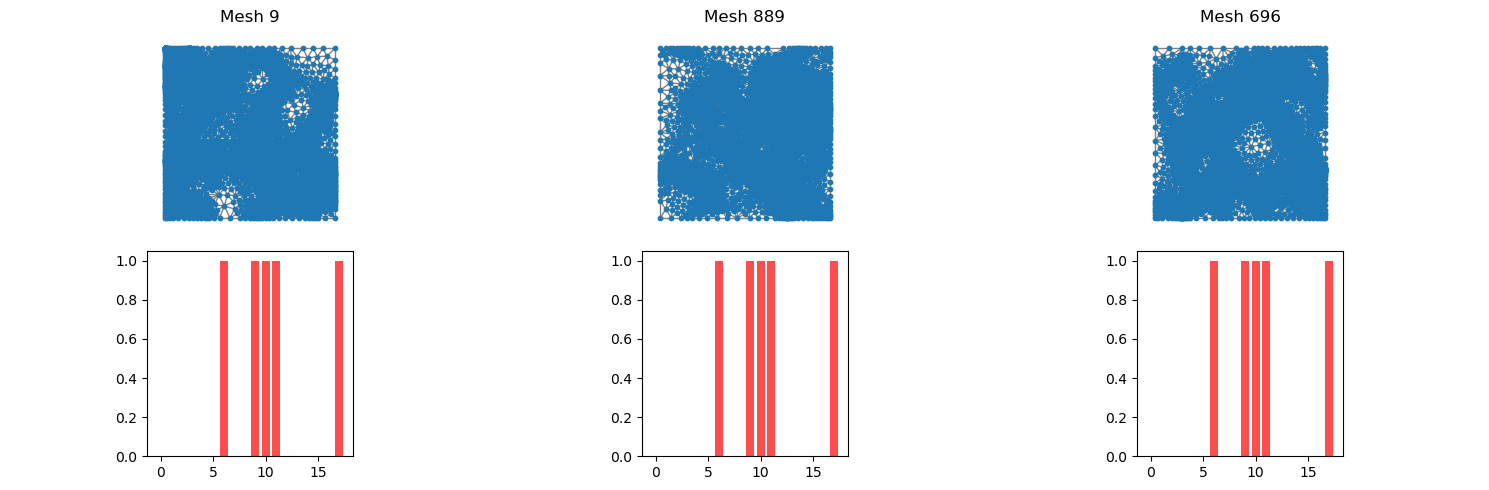

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

for i in range(3):
    data = dataset[i+50]
    G = to_networkx(data, to_undirected=True)
    
    # Use node coordinates for layout
    pos = {j: (data.x[j][0].item(), data.x[j][1].item()) for j in range(data.num_nodes)}
    
    ax = axes[0,i]
    nx.draw(
        G, pos=pos, ax=ax, node_size=10, edge_color="gray"
    )
    ax.set_title(f"Mesh {data.mesh_id}")
    ax.axis("equal")
    ax.axis("off")

    ax = axes[1,i]
    ax.bar(range(len(data.y_conv)),data.y_conv.numpy(), color='red', alpha=0.7)
    ax.set_box_aspect(1) 

plt.tight_layout()
plt.show()


## Create the model

Import needed packages

In [18]:
# For building the neural network
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool

# For data splitting and loading
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.utils.data import random_split


# For training
import torch.optim as optim

## MultiTask Learning Model

In [16]:
class SolverTimeNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=21):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        #self.conv2 = GCNConv(hidden_dim, hidden_dim)
        #self.conv3 = GCNConv(hidden_dim, hidden_dim)

        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)

        # Two output heads
        self.conv_head = torch.nn.Linear(hidden_dim, output_dim)  # Convergence classification (binary)
        self.time_head = torch.nn.Linear(hidden_dim, output_dim)  # Time regression (real-valued)

    def forward(self, x, edge_index, batch):
        # GCN layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = self.conv2(x, edge_index)
        #x = F.relu(x)
        #x = self.conv3(x, edge_index)
        #x = F.relu(x)

        # Graph-level embedding
        x = global_mean_pool(x, batch)


        # Inspect graph-level embedding before the output heads
        #print("Graph embedding stats:", x.mean().item(), x.std().item())


        x = self.lin1(x)
        x = F.relu(x)

        # Output heads
        y_conv = self.conv_head(x)       # Shape: [batch_size, 21]
        y_time = self.time_head(x)       # Shape: [batch_size, 21]

        return y_conv, y_time


In [19]:
from torch import nn
from torch_geometric.nn import EdgeConv
from torch_scatter import scatter_add


class EdgeMeshNet(nn.Module):
    
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=21,
                 min_nodes=0, max_nodes=1, min_edges=0, max_edges=1):
        super().__init__()
        self.min_nodes = min_nodes
        self.max_nodes = max_nodes
        self.min_edges = min_edges
        self.max_edges = max_edges

        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
              
        self.conv1 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * input_dim, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ))

        self.conv2 = EdgeConv(nn=nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim,bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ))

        # MLP after pooling + normalized size features
        self.lin1 = nn.Linear(hidden_dim + 2, hidden_dim)
        self.relu = nn.ReLU()

        # Output heads
        self.conv_head = nn.Linear(hidden_dim, output_dim,bias=False)  # classification
        self.time_head = nn.Linear(hidden_dim, output_dim,bias=False)  # regression

    def forward(self, x, edge_index, batch):
        # EdgeConv layers
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index)))


        # Dropout before pooling
        x = F.dropout(x, p=0.3, training=self.training)

        # Global mean pooling
        x_pool = global_mean_pool(x, batch)  # [num_graphs, hidden_dim]

        # Correct number of nodes per graph
        num_nodes = scatter_add(torch.ones_like(batch), batch, dim=0).unsqueeze(1)  # [B, 1]

        # Correct number of edges per graph
        row, _ = edge_index
        edge_batch = batch[row]
        num_edges = scatter_add(torch.ones_like(edge_batch), edge_batch, dim=0).unsqueeze(1)  # [B, 1]

        # Normalize node and edge counts using min-max
        num_nodes = (num_nodes - self.min_nodes) / (self.max_nodes - self.min_nodes + 1e-6)
        num_edges = (num_edges - self.min_edges) / (self.max_edges - self.min_edges + 1e-6)

        # Combine features
        x_combined = torch.cat([x_pool, num_nodes, num_edges], dim=1)

        # MLP and heads
        x_combined = self.relu(self.lin1(x_combined))
        y_conv_logits = self.conv_head(x_combined)
        y_time = self.time_head(x_combined)

        return y_conv_logits, y_time

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)




In [20]:
print("Node feature dim:", dataset[0].x.shape[1])
print("Target vector dim:", dataset[0].y_conv.shape[0])
print("Target vector dim:", dataset[0].y_time.shape[0])



Node feature dim: 3

Target vector dim: 18

Target vector dim: 18


Split data and make dataset for  batch training. Pre-select and save batches (for relatively small datasets).

In [21]:
# Set random seed for reproducibility
torch.manual_seed(24)

# Define split sizes
total_len = len(dataset)
train_len = int(0.8 * total_len)
test_len = total_len - train_len

train_dataset, test_dataset = random_split(dataset, [train_len, test_len])


batch_size = 64  # Set to 450 for full batch, or specify a number for mini-batches

def create_static_batches(dataset, batch_size):
    batches = []
    for i in range(0, len(dataset), batch_size):
        with contextlib.redirect_stdout(None):
            batch = Batch.from_data_list(dataset[i:i+batch_size])
        batches.append(batch)
    return batches

train_batches = create_static_batches(train_dataset, batch_size=batch_size)
test_batches = create_static_batches(test_dataset, batch_size=batch_size)

print(f"Pre-batched {len(train_batches)} train batches and {len(test_batches)} test batches")


Pre-batched 6 train batches and 2 test batches


In [22]:
train_nodes = []
train_edges = []
with contextlib.redirect_stdout(None):
        for data in train_dataset:
                train_nodes.append(data.num_nodes)
                train_edges.append(data.edge_index.size(1))

min_nodes = min(train_nodes)
max_nodes = max(train_nodes)
min_edges = min(train_edges)
max_edges = max(train_edges)

print(f"Node count: min={min_nodes}, max={max_nodes}")
print(f"Edge count: min={min_edges}, max={max_edges}")


Node count: min=3282, max=24073
Edge count: min=19347, max=143649


In [19]:
for i in range(5):
    print(repr(train_dataset[i]))


Data(x=[12532, 3], edge_index=[2, 74658], y_time=[21], y_conv=[21], mesh_id=840)

Data(x=[8843, 3], edge_index=[2, 52548], y_time=[21], y_conv=[21], mesh_id=507)

Data(x=[5968, 3], edge_index=[2, 35007], y_time=[21], y_conv=[21], mesh_id=896)

Data(x=[4375, 3], edge_index=[2, 25827], y_time=[21], y_conv=[21], mesh_id=180)

Data(x=[4156, 3], edge_index=[2, 24414], y_time=[21], y_conv=[21], mesh_id=844)


In [23]:
max_nodes - min_nodes

20791

In [24]:
m = dataset[0].y_conv.shape[0]

In [25]:
# gnn_model = SolverTimeNet(
#     input_dim = 3,
#     hidden_dim = 64,
#     output_dim = 21
# ).to(device)
gnn_model = EdgeMeshNet(
     input_dim = 3,
     hidden_dim = 16,
     output_dim = m,
     min_nodes= min_nodes,
     max_nodes=max_nodes, 
     min_edges = min_edges,
     max_edges=max_edges
 ).to(device)

print(gnn_model)

num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")


gnn_model.apply(init_weights)

EdgeMeshNet(
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=16, bias=False)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (conv2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=16, bias=False)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (lin1): Linear(in_features=18, out_features=16, bias=True)
  (relu): ReLU()
  (conv_head): Linear(in_features=16, out_features=18, bias=False)
  (time_head): Linear(in_features=16, out_features=18, bias=False)
)
Number of trainable parameters: 2096


EdgeMeshNet(
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=16, bias=False)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (conv2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=16, bias=False)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (lin1): Linear(in_features=18, out_features=16, bias=True)
  (relu): ReLU()
  (conv_head): Linear(in_features=16, out_features=18, bias=False)
  (time_head): Linear(in_features=16, out_features=18, bias=False)
)

In [26]:
def multitask_loss(y_conv_pred, y_time_pred, y_conv_true, y_time_true, alpha=1.0):
    # Binary classification loss
    loss_class = F.binary_cross_entropy_with_logits(y_conv_pred, y_conv_true)

    # Mask: apply regression loss only to converged entries
    mask = y_conv_true.bool()
    if mask.sum() > 0:
        loss_reg = F.mse_loss(y_time_pred[mask], y_time_true[mask])
    else:
        loss_reg = 0.0

    return loss_class + alpha * loss_reg


In [308]:
def multitask_loss2(y_conv_pred, y_time_pred, y_conv_true, y_time_true, alpha=1.0):
    """
    if alpha = 1, it is purely regression loss, if alpha = 0, it is purely classification loss
    """
    # Binary classification loss
    loss_class = F.binary_cross_entropy_with_logits(y_conv_pred, y_conv_true)
    # Regression loss
    loss_reg = F.mse_loss(y_time_pred, y_time_true)
    
    return (1-alpha)*loss_class + alpha * loss_reg

This needs to be fixed, the 'batch.y.view(-1,21)' is hard-coded now for both, train and evaluate

In [31]:
def train_epoch_static(model, batches, optimizer, device, alpha=1.0):
    m=model.conv_head.out_features
    model.train()
    total_loss = 0
    for batch in batches:
        batch = batch.to(device)
        optimizer.zero_grad()

        y_conv_logits, y_time_pred = model(batch.x, batch.edge_index, batch.batch)

        # Reshape targets
        y_conv_true = batch.y_conv.view(-1, m)
        y_time_true = batch.y_time.view(-1, m)

        loss = multitask_loss(
            y_conv_logits, y_time_pred,
            y_conv_true, y_time_true,
            alpha=alpha
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / sum(batch.num_graphs for batch in batches)



def evaluate_epoch_static(model, batches, device, alpha=1.0):
    m=model.conv_head.out_features
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in batches:
            batch = batch.to(device)
            y_conv_logits, y_time_pred = model(batch.x, batch.edge_index, batch.batch)

            # Reshape targets
            y_conv_true = batch.y_conv.view(-1, m)
            y_time_true = batch.y_time.view(-1, m)

            loss = multitask_loss(
                y_conv_logits, y_time_pred,
                y_conv_true, y_time_true,
                alpha=alpha
            )

            total_loss += loss.item() * batch.num_graphs
    return total_loss / sum(batch.num_graphs for batch in batches)


Lets make one forward pass to check!

In [32]:
data = dataset[0].to(device)

gnn_model.eval()  # set to evaluation mode
with torch.no_grad():
    # All nodes belong to graph 0 → batch_vector is all zeros
    batch_vector = torch.zeros(data.num_nodes, dtype=torch.long, device=device)

    # Run the model (returns two outputs)
    y_conv_logits, y_time_pred = gnn_model(data.x, data.edge_index, batch_vector)

    # Optional: convert logits to probabilities for interpretation
    y_conv_prob = torch.sigmoid(y_conv_logits)

print("Output shapes:")
print("  y_conv_logits:", y_conv_logits.shape)  # should be (1, 21)
print("  y_time_pred  :", y_time_pred.shape)    # should be (1, 21)

print("\nConvergence probabilities (sigmoid):")
print(y_conv_prob.cpu().numpy())

print("\nPredicted -log(times):")
print(y_time_pred.cpu().numpy())



Output shapes:
  y_conv_logits: torch.Size([1, 18])
  y_time_pred  : torch.Size([1, 18])

Convergence probabilities (sigmoid):
[[0.6739909  0.5533283  0.54888165 0.42761442 0.4669895  0.5624527
  0.6208437  0.5217229  0.560076   0.591241   0.45848787 0.5176272
  0.52798444 0.40635288 0.5159969  0.63897353 0.6341103  0.73126954]]

Predicted -log(times):
[[-0.29934207  0.12492713  0.19095062  0.00478811 -0.14323372  0.3981347
   0.7581721  -0.5890936   0.49596858  0.3143786  -0.2577157  -0.35505545
   0.09132342 -0.09004072 -0.2915715  -0.00813306 -0.5348867  -0.4726727 ]]


## Train the model

In [34]:
m = dataset[0].y_conv.shape[0]

In [35]:
gnn_model = EdgeMeshNet(
     input_dim = 3,
     hidden_dim = 16,
     output_dim = m,
     min_nodes= min_nodes,
     max_nodes=max_nodes, 
     min_edges = min_edges,
     max_edges=max_edges
 ).to(device)

print(gnn_model)

num_params = sum(p.numel() for p in gnn_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")


gnn_model.apply(init_weights) # reinitiate

EdgeMeshNet(
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=16, bias=False)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (conv2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=16, bias=False)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (lin1): Linear(in_features=18, out_features=16, bias=True)
  (relu): ReLU()
  (conv_head): Linear(in_features=16, out_features=18, bias=False)
  (time_head): Linear(in_features=16, out_features=18, bias=False)
)
Number of trainable parameters: 2096


EdgeMeshNet(
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=16, bias=False)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (conv2): EdgeConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=16, bias=False)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
  ))
  (lin1): Linear(in_features=18, out_features=16, bias=True)
  (relu): ReLU()
  (conv_head): Linear(in_features=16, out_features=18, bias=False)
  (time_head): Linear(in_features=16, out_features=18, bias=False)
)

In [36]:
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)


In [37]:
train_losses = []
test_losses = []

In [50]:
n_epochs=10


alpha = 0.01 # 1: Purely regression loss, 0: Purely classification loss (with multitask loss without mask!)

for epoch in range(1, n_epochs + 1):
    t0 = time.time()
    train_loss = train_epoch_static(gnn_model, train_batches, optimizer, device, alpha=alpha)
    t1 = time.time()
    test_loss = evaluate_epoch_static(gnn_model, test_batches, device, alpha=alpha)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Time Spent: {t1-t0:.2f} s")


Epoch 001 | Train Loss: 0.5177 | Test Loss: 0.5092 | Time Spent: 15.06 s
Epoch 002 | Train Loss: 0.4988 | Test Loss: 0.4900 | Time Spent: 14.73 s
Epoch 003 | Train Loss: 0.4803 | Test Loss: 0.4717 | Time Spent: 14.89 s
Epoch 004 | Train Loss: 0.4626 | Test Loss: 0.4546 | Time Spent: 15.00 s
Epoch 005 | Train Loss: 0.4452 | Test Loss: 0.4376 | Time Spent: 15.04 s
Epoch 006 | Train Loss: 0.4287 | Test Loss: 0.4205 | Time Spent: 14.90 s
Epoch 007 | Train Loss: 0.4129 | Test Loss: 0.4040 | Time Spent: 14.90 s
Epoch 008 | Train Loss: 0.3982 | Test Loss: 0.3900 | Time Spent: 15.07 s
Epoch 009 | Train Loss: 0.3848 | Test Loss: 0.3791 | Time Spent: 15.11 s
Epoch 010 | Train Loss: 0.3725 | Test Loss: 0.3688 | Time Spent: 15.08 s


In [51]:
for name, param in gnn_model.named_parameters():
    if param.grad is not None:
        print(name, param.grad.abs().mean())


bn1.weight tensor(0.0008, device='cuda:0')
bn1.bias tensor(0.0008, device='cuda:0')
bn2.weight tensor(0.0032, device='cuda:0')
bn2.bias tensor(0.0039, device='cuda:0')
conv1.nn.0.weight tensor(0.0007, device='cuda:0')
conv1.nn.2.weight tensor(0.0004, device='cuda:0')
conv1.nn.2.bias tensor(3.9067e-09, device='cuda:0')
conv2.nn.0.weight tensor(0.0003, device='cuda:0')
conv2.nn.2.weight tensor(0.0004, device='cuda:0')
conv2.nn.2.bias tensor(1.9505e-09, device='cuda:0')
lin1.weight tensor(0.0019, device='cuda:0')
lin1.bias tensor(0.0040, device='cuda:0')
conv_head.weight tensor(0.0049, device='cuda:0')
time_head.weight tensor(0.0004, device='cuda:0')


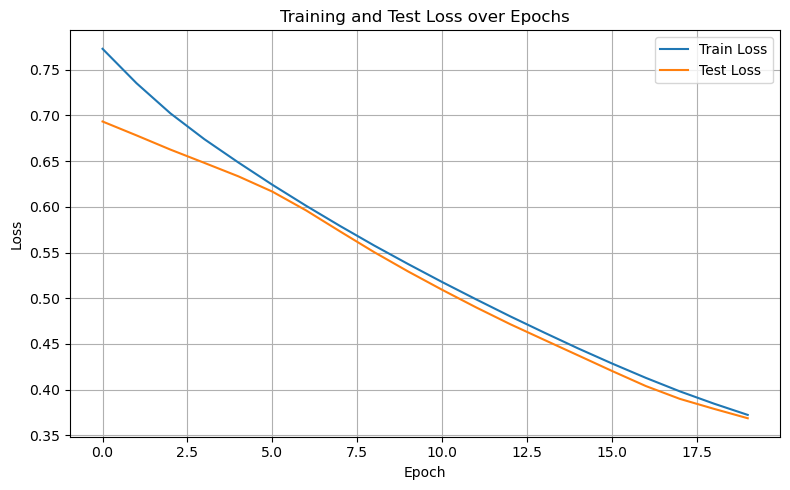

In [52]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_losses[0:], label='Train Loss')
plt.plot(test_losses[0:], label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Understand Predicitons

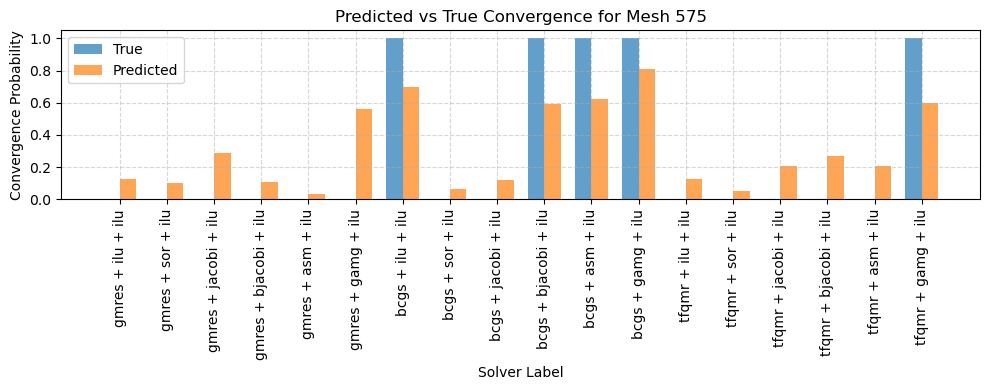

In [53]:
# Select one sample from test_dataset
data = test_dataset[0].to(device)


# Prepare batch vector (all zeros for a single graph)
batch_vector = torch.zeros(data.num_nodes, dtype=torch.long, device = device)

# Model to eval mode
gnn_model.eval()
with torch.no_grad():
    y_conv_logits, y_time_pred = gnn_model(data.x, data.edge_index, batch_vector)
    y_conv_prob = torch.sigmoid(y_conv_logits.view(-1,m)) 
    
    y_conv_true = data.y_conv; y_time_true = data.y_time
    # Convert to NumPy for plotting
y_conv_prob= y_conv_prob.detach().cpu().numpy()
y_time_pred = y_time_pred.detach().cpu().numpy()

y_conv_true= y_conv_true.detach().cpu().numpy()
y_time_true = y_time_true.detach().cpu().numpy()

# Convert to NumPy and flatten
y_conv_prob = y_conv_prob.flatten()
y_time_pred = y_time_pred.flatten()
y_conv_true = y_conv_true.flatten()
y_time_true = y_time_true.flatten()

# Plot
plt.figure(figsize=(10, 4))
width = 0.35
indices = range(len(y_conv_true))

labels = df['Solver Label'].values[0:m]

plt.bar([i - width/2 for i in indices], y_conv_true, width=width, label="True", alpha=0.7)
plt.bar([i + width/2 for i in indices], y_conv_prob, width=width, label="Predicted", alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Solver Label")
plt.xticks(indices, labels, rotation=90)
plt.ylabel("Convergence Probability")
plt.title(f"Predicted vs True Convergence for Mesh {data.mesh_id}")
plt.legend()
plt.tight_layout()
plt.show()


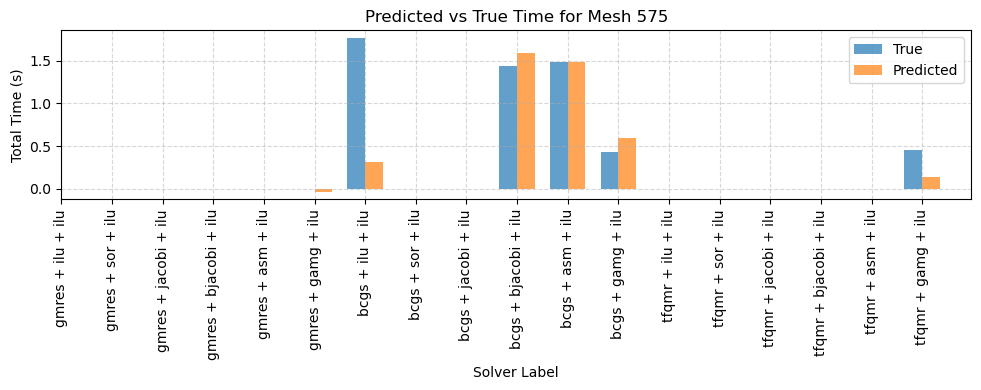

In [54]:
# Plot
plt.figure(figsize=(10, 4))
width = 0.35
indices = range(len(y_conv_true))

labels = df['Solver Label'].values[0:m]

y_time_true[y_conv_true<0.5] = None
y_time_pred[y_conv_prob<0.5] = None

plt.bar([i - width/2 for i in indices], y_time_true, width=width, label="True", alpha=0.7)
plt.bar([i + width/2 for i in indices], y_time_pred, width=width, label="Predicted", alpha=0.7)
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Solver Label")
plt.xticks(indices, labels, rotation=90)
plt.ylabel("Total Time (s)")
plt.title(f"Predicted vs True Time for Mesh {data.mesh_id}")
plt.legend()
plt.tight_layout()
plt.show()

In [271]:
from sklearn.metrics import f1_score


# Step 1: Collect predictions and labels
all_logits = []
all_targets = []

gnn_model.eval()
with torch.no_grad():
    for batch in train_batches:
        batch = batch.to(device)
        y_logits, _ = gnn_model(batch.x, batch.edge_index, batch.batch)
        y_true = batch.y_conv.view(-1, 21)
        
        all_logits.append(y_logits.cpu())
        all_targets.append(y_true.cpu())

# Combine
logits = torch.cat(all_logits).numpy()       # shape [N, 21]
targets = torch.cat(all_targets).numpy()     # shape [N, 21]

# Step 2: Compute optimal threshold per class
optimal_thresholds = []
threshold_range = np.linspace(0.0, 1.0, 101)

for i in range(21):
    best_thresh = 0.5
    best_f1 = 0.0
    for thresh in threshold_range:
        preds = (torch.sigmoid(torch.tensor(logits[:, i])) > thresh).int()
        f1 = f1_score(targets[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    optimal_thresholds.append(best_thresh)

optimal_thresholds = np.array(optimal_thresholds)
print("Optimal thresholds per solver combination:")
print(optimal_thresholds)


Optimal thresholds per solver combination:
[0.5  0.   0.5  0.5  0.5  0.5  0.09 0.23 0.   0.5  0.5  0.23 0.24 0.59
 0.07 0.   0.5  0.5  0.06 0.05 0.4 ]


In [55]:
from collections import Counter

gnn_model.eval()
predicted_patterns = []
true_patterns = []

with torch.no_grad():
    with contextlib.redirect_stdout(None):
        for data in test_dataset:
        
            data = data.to(device)
            batch_vector = torch.zeros(data.num_nodes, dtype=torch.long, device=device)

            y_conv_logits, _ = gnn_model(data.x, data.edge_index, batch_vector)
            y_conv_true = data.y_conv.int().cpu().numpy().flatten()
            y_conv_pred = (torch.sigmoid(y_conv_logits) > 0.5).int().cpu().numpy().flatten() # OR...
            #y_conv_pred = (torch.sigmoid(y_conv_logits)> torch.tensor(optimal_thresholds, device=device)).int().cpu().numpy().flatten()


            pattern_str = ''.join(map(str, y_conv_pred.tolist()))
            predicted_patterns.append(pattern_str)

            pattern_str = ''.join(map(str, y_conv_true.tolist()))
            true_patterns.append(pattern_str)

# Count unique predicted patterns
predicted_pattern_counter= Counter(predicted_patterns)
true_pattern_counter= Counter(true_patterns)

print(f"🔍 Unique predicted convergence patterns in the data: {len(predicted_pattern_counter)} / {len(test_dataset)}")
print(f"🔍 Unique true convergence patterns in the data: {len(true_pattern_counter)} / {len(test_dataset)}")
print("\nTop 10 predicted patterns in the data:\n")
for pattern, count in true_pattern_counter.most_common(9):
    print(f"{pattern}    {count}")

print("\nTop 10 predicted patterns in the data:\n")
for pattern, count in predicted_pattern_counter.most_common(9):
    print(f"{pattern}    {count}")

🔍 Unique predicted convergence patterns in the data: 7 / 90
🔍 Unique true convergence patterns in the data: 9 / 90

Top 10 predicted patterns in the data:

000000000000000000    16
000000100111000001    13
000000000001000000    12
000001100111000001    9
000001100111100111    9
000000100110000000    8
000000100111100111    8
000000000001000001    8
000001000001000001    7

Top 10 predicted patterns in the data:

000001100111000001    75
000000100111000000    4
000001100011000001    4
000001100001000001    2
000000100111000001    2
000001100111000000    2
000001000001000000    1


In [155]:
y_conv_true = data.y_conv.int().cpu().numpy().flatten()

print(y_conv_true)

[0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0]


In [ ]:
indx_pred = np.argmin(np.exp(-y_pred))
indx_true = np.argmin(np.exp(-y_true))



print(f"Predicted solver: {labels[indx_pred]},   Total Time (s): {np.exp(-y_pred[indx_pred]):.5f} // vs {np.exp(-y_pred[indx_true]):.5f}")
print(f"True solver:      {labels[indx_true]},   Total Time (s): {np.exp(-y_true[indx_true]):.5f} // vs {np.exp(-y_true[indx_pred]):.5f}")
#print("---------------------------------------------------------------------------------")
#print(f"Predicted solver time for  {labels[indx_true]} is {np.exp(-y_pred[indx_true]):.5f}")
#print(f"True solver time for  {labels[indx_pred]} is {np.exp(-y_true[indx_pred]):.5f}")


In [ ]:
print(y_true)
print(y_pred)


### Accuracy for the training set:

In [ ]:
# Forward pass
gnn_model.eval()
with torch.no_grad():
    y_pred = gnn_model(train_batch.x, train_batch.edge_index, train_batch.batch).numpy()
    y_true = train_batch.y.view(-1,21).numpy()

# Transform back from -log to positive time
y_pred_times = np.exp(-y_pred)
y_true_times = np.exp(-y_true)

pred_best = np.argmin(y_pred_times, axis=1)
true_best = np.argmin(y_true_times, axis=1)

matches = np.sum(pred_best == true_best)
total = len(pred_best)

print(f"Correct best solver prediction in {matches} out of {total} test cases, {100*matches/total: .2f} % accuracy.")

### Accuracy for the test set:


In [ ]:
# Forward pass
gnn_model.eval()
with torch.no_grad():
    y_pred = gnn_model(test_batch.x, test_batch.edge_index, test_batch.batch).numpy()
    y_true = test_batch.y.view(-1,21).numpy()

# Transform back from -log to positive time
y_pred_times = np.exp(-y_pred)
y_true_times = np.exp(-y_true)

pred_best = np.argmin(y_pred_times, axis=1)
true_best = np.argmin(y_true_times, axis=1)

aux = np.array(range(len(pred_best)))
dT_pp = y_pred_times[aux, pred_best] - y_pred_times[aux,true_best]
dT_tt = y_true_times[aux,pred_best] - y_true_times[aux,true_best]
dT_pt = y_pred_times[aux,pred_best] - y_true_times[aux,true_best]

matches = np.sum(pred_best == true_best)
total = len(pred_best)

print(f"Correct best solver prediction in {matches} out of {total} test cases,{100*matches/total: .2f} % accuracy.")

In [ ]:
print(pred_best)
print(true_best)

In [ ]:
plt.hist(true_best, bins=21, alpha=0.5, label='True Best Solver', color='blue' );
plt.hist(pred_best, bins=1, alpha=0.5, label='Predicted Best Solver', color='orange');
plt.xlabel('Solver Index')
plt.xticks(indices);
plt.legend()
plt.show()  

In [ ]:
plt.hist(y_true.flatten(), bins=60, alpha=0.5, label='Distr of all true times (log)', color='blue' );
plt.hist(y_pred.flatten(), bins=60, alpha=0.5, label='Distr of all predicted times (log)', color='orange');
plt.xlabel('Times')
plt.legend()
plt.show()

In [ ]:
plt.hist(y_true.flatten() - y_pred.flatten(), bins=30, alpha=0.5, label='Distr of all true times (log)', color='blue' );
plt.xlabel('Times')
plt.legend()
plt.show()

In [ ]:
plt.hist(dT_pp, bins=20, alpha=0.5, label='Predicted - Predicted Best');
plt.hist(dT_tt, bins=20, alpha=0.5, label='True - True Best');
plt.hist(dT_pt, bins=20, alpha=0.5, label='True - Predicted Best');